## Imports

In [1]:
% matplotlib inline
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [3]:
path = Path('..', 'data', 'bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        _,  _, _, topic, file_name = file.parts

        lines = f.readlines()
        file_id = file_name.split('.')[0]
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic, heading, body])

### Convert to DataFrame

In [4]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
article    2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


### Inspect results

In [5]:
docs.sample(10)

,topic,heading,article
2015,entertainment,Singer's film to show at festival,A documentary which takes a candid look at th...
1895,entertainment,US TV special for tsunami relief,A US television network will screen a celebri...
1437,business,Cairn Energy in Indian gas find,"Shares in Cairn Energy rose 3.8% to 1,088 pen..."
2038,entertainment,No charges against TV's Cosby,US comedian Bill Cosby will not face charges ...
192,tech,Video phone help for deaf people,Deaf people who prefer to communicate using B...
1383,business,$1m payoff for former Shell boss,"Shell is to pay $1m (Â£522,000) to the ex-fin..."
1515,business,Disaster claims 'less than $10bn',Insurers have sought to calm fears that they ...
124,tech,Gizmondo gadget hits the shelves,"The Gizmondo combined media player, phone and..."
1646,business,Low-cost airlines hit Eurotunnel,Channel Tunnel operator Eurotunnel has seen s...
252,tech,Honour for UK games maker,Leading British computer games maker Peter Mo...


In [6]:
# word count
docs.article.str.split().str.len().sum()

842910

### Data drawn from 5 different categories

In [7]:
docs.topic.value_counts(normalize=True)

sport           0.23
business        0.23
politics        0.19
tech            0.18
entertainment   0.17
Name: topic, dtype: float64

## Prepare Document-Term Matrix

In [8]:
print(CountVectorizer().__doc__)

Convert a collection of text documents to a matrix of token counts

    This implementation produces a sparse representation of the counts using
    scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer
    that does some kind of feature selection then the number of features will
    be equal to the vocabulary size found by analyzing the data.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be the sequence strings or
        bytes items are expected to be analyzed directly.

    encoding

### Baseline document-term matrix

In [9]:
# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [10]:
doc_term_matrix.shape

(2225, 29275)

### Inspect tokens

In [11]:
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

['00',
 '000',
 '0001',
 '000bn',
 '000m',
 '000s',
 '000th',
 '001',
 '001and',
 '001st']

### Inspect doc-term matrix

In [12]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Most frequent terms

In [13]:
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head() 

the    52574
to     24767
of     19930
and    18574
in     17553
dtype: int64

### Compute relative term frequency

In [14]:
vectorizer = CountVectorizer(binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 29275)

In [15]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(
    docs.shape[0]).sort_values(ascending=False).head(10)

the    1.00
to     1.00
of     0.99
and    0.99
in     0.99
for    0.93
on     0.91
is     0.86
it     0.86
said   0.85
dtype: float64

### Visualize Doc-Term Matrix

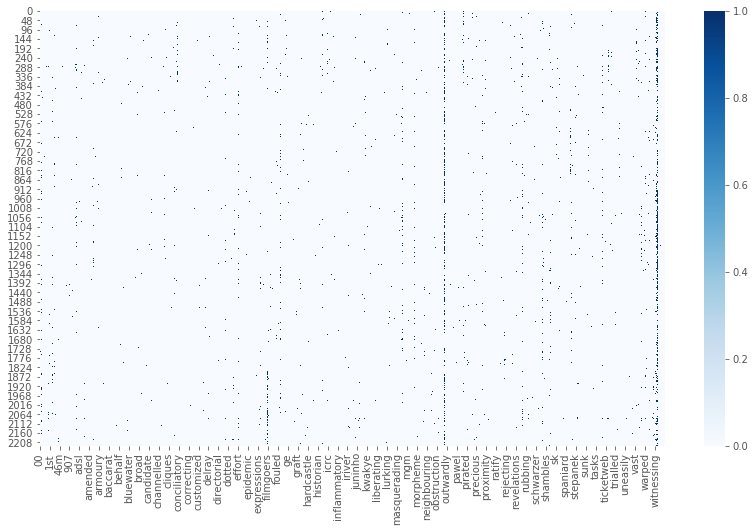

In [16]:
sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8);

### Using thresholds to reduce the number of tokens 

In [17]:
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 12789)

### Use CountVectorizer with Lemmatization

#### Building a custom `tokenizer` for Lemmatization with `spacy`

In [18]:
nlp = spacy.load('en')
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc) 
                if not w.is_punct | w.is_space]

In [19]:
vectorizer = CountVectorizer(tokenizer=tokenizer, binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 25073)

In [20]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=lemmatized_words).div(docs.shape[0])
word_freq_1d.sort_values().tail(20)

from     0.70
but      0.73
as       0.74
by       0.77
at       0.79
with     0.82
that     0.83
say      0.88
's       0.90
on       0.91
for      0.93
have     0.97
in       0.99
and      0.99
of       0.99
a        0.99
-PRON-   1.00
to       1.00
be       1.00
the      1.00
dtype: float64

Unlike verbs and common nouns, there's no clear base form of a personal pronoun. Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.

### TfIdf Vectorizer 

In [21]:
print(TfidfTransformer().__doc__)

Transform a count matrix to a normalized tf or tf-idf representation

    Tf means term-frequency while tf-idf means term-frequency times inverse
    document-frequency. This is a common term weighting scheme in information
    retrieval, that has also found good use in document classification.

    The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.

    The formula that is used to compute the tf-idf of term t is
    tf-idf(d, t) = tf(t) * idf(d, t), and the idf is computed as
    idf(d, t) = log [ n / df(d, t) ] + 1 (if ``smooth_idf=False``),
    where n is the total number of documents and df(d, t) is the
    document frequency; the document frequency is the number of documents d
    that contain term t. The effect of addi

In [22]:
tfidf = TfidfVectorizer()
doc_term_matrix = tfidf.fit_transform(docs.article)
doc_term_matrix.shape

(2225, 29275)

In [23]:
words = tfidf.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=words)
word_freq_1d.sort_values().tail(20) 

are     53.42
have    54.73
as      55.83
has     56.23
with    57.27
will    57.99
be      63.05
was     68.57
on      75.63
said    78.80
it      79.05
he      79.85
that    82.59
is      84.27
for     84.30
in     165.16
and    166.06
of     177.76
to     221.14
the    475.64
dtype: float64

## Create Train & Test Sets

In [24]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [25]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [26]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
politics          9
tech              9
entertainment     9
Name: topic, dtype: int64

### Vectorize train & test sets

In [27]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178572 stored elements in Compressed Sparse Row format>

In [28]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4160 stored elements in Compressed Sparse Row format>